# Data Import

In [1]:
# Mount Google drive to the coding space
#from google.colab import drive

#drive.mount('/content/drive/')

In [6]:
# Check if directory exist
#!ls "/content/drive/MyDrive/APS360/APS360_Group/data"


print("PyTorch version:", torch.__version__)
print("CUDA available? ", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected by PyTorch")

PyTorch version: 2.5.1+cu121
CUDA available?  True
GPU name: NVIDIA GeForce RTX 4060


In [7]:
# Import Libraries
import torch
import os
import numpy as np
import pandas as pd

In [8]:
label_df = pd.read_csv('C:/Users/namgy/OneDrive/Desktop/APS360/data/unrestricted_5_22_56_15.csv')
#print(label_df.columns)

label_df['Subject'] = label_df['Subject'].astype(str)

trait_columns = ['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']
label_map = {
    row['Subject']: row[trait_columns].values.astype(np.float32)
    for _, row in label_df.iterrows()
}

# Dataset Initialization

In [9]:
# Dataset Class

from torch.utils.data import Dataset


class fconnDataset(Dataset):
    def __init__(self, root_dir, target_network=None, label_map=None, transform=None):
        """
        Args:
            root_dir (str): Root directory with patient folders.
            target_network (int): Loads a specific network from each patient.
            label_map (dict): Mapping of patient IDs to labels.
            transform (callable): Optional transform to apply to each matrix.
        """
        self.root_dir = root_dir
        self.target_network = target_network
        self.label_map = label_map
        self.transform = transform

        valid_patients = []

        for patient_name in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_name)
            patient_id = os.path.basename(patient_path).replace("subject_", "")
            # Only add patients with network data into valid_patients array
            if os.path.isdir(patient_path) and os.listdir(patient_path):
              label = label_map[patient_id]
              if np.isnan(label).any():
                  continue
              valid_patients.append(patient_path)



        self.valid_patients = valid_patients

    def __len__(self):
        return len(self.valid_patients)

    def __getitem__(self, idx):
        patient_path = self.valid_patients[idx]
        patient_id = os.path.basename(patient_path).replace("subject_", "")

        file_path = os.path.join(patient_path, f"net_{self.target_network:02d}.npy")
        data = np.load(file_path)
        tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # [1, N, 10]

        if self.transform:
            tensor = self.transform(tensor)

        label_array = self.label_map.get(patient_id, np.full(5, np.nan, dtype=np.float32))
        label_tensor = torch.tensor(label_array, dtype=torch.float32)

        return tensor, label_tensor

    def getpatientid(self, idx):
        patient_path = self.valid_patients[idx]
        patient_id = os.path.basename(patient_path).replace("subject_", "")

        return patient_id

In [11]:
# Create dataset
# Around 2 min run time

dataset = fconnDataset(root_dir='C:/Users/namgy/OneDrive/Desktop/APS360/data/output', label_map=label_map,target_network=8)

# Standard 80% training, 10% validation, 10% test dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [12]:
# Check correlation

X = []
Y = []
for i in range(len(train_dataset)):
    #print(f'{i+1}/{len(train_dataset)}')
    x, y = train_dataset[i]
    X.append(x.reshape(-1).numpy())
    Y.append(y.numpy())

df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y, columns=['A', 'O', 'C', 'N', 'E'])

for trait in df_Y.columns:
    correlations = df_X.corrwith(df_Y[trait])
    print(f"{trait} | Top correlations:\n", correlations.abs().sort_values(ascending=False).head(5))

A | Top correlations:
 633     0.118107
556     0.116451
3153    0.116218
2986    0.113355
3683    0.112991
dtype: float64
O | Top correlations:
 3814    0.120956
9104    0.115806
224     0.114740
6764    0.111257
5494    0.110811
dtype: float64
C | Top correlations:
 1917    0.124257
1897    0.122604
217     0.119464
1877    0.107694
1907    0.107403
dtype: float64
N | Top correlations:
 5884    0.117378
9954    0.116870
5338    0.116052
5464    0.115774
6548    0.115197
dtype: float64
E | Top correlations:
 16      0.126293
4266    0.125902
1186    0.125634
4316    0.125505
4426    0.125332
dtype: float64


✅ Best network per trait (based on highest absolute correlation):

- A: Network 06 | Max Correlation: 0.3688
- O: Network 16 | Max Correlation: 0.3800
- C: Network 09 | Max Correlation: 0.4066
- N: Network 03 | Max Correlation: 0.3968
- E: Network 08 | Max Correlation: 0.3878

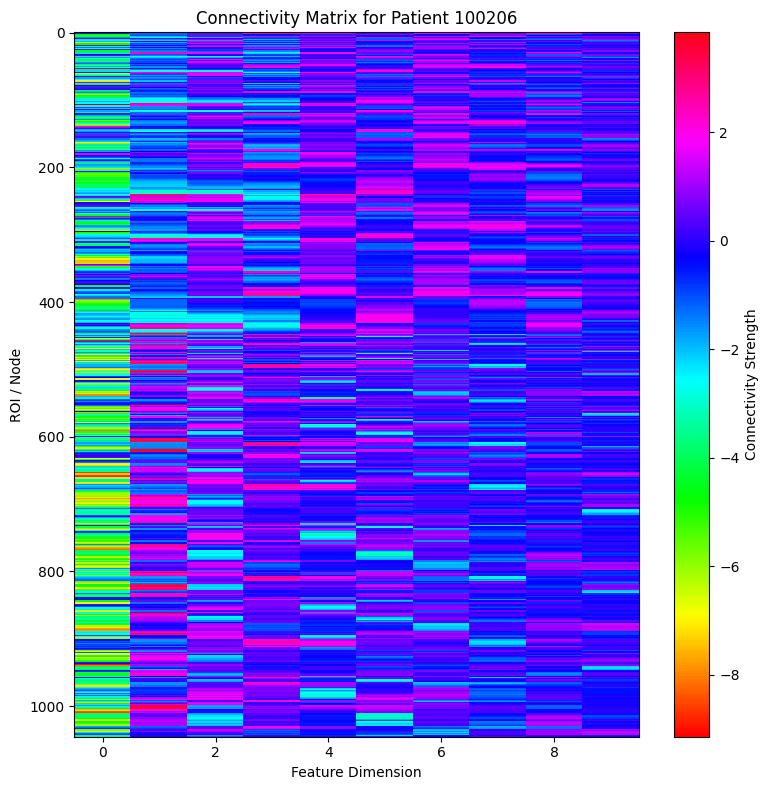

In [14]:
# Plot to ensure data is correct

import matplotlib.pyplot as plt
from matplotlib import colormaps
# Pick a sample (e.g., the 0th patient)
matrix, tensor = dataset[1]
patient_id = dataset.getpatientid(0)
matrix = matrix.squeeze(0)       # [N, 10]

plt.figure(figsize=(8, 8))
plt.imshow(matrix, cmap='hsv', aspect='auto', interpolation='none')
plt.colorbar(label='Connectivity Strength')
plt.title(f'Connectivity Matrix for Patient {patient_id}')
plt.xlabel("Feature Dimension")
plt.ylabel("ROI / Node")
plt.tight_layout()
plt.show()

# Hyperparameters

In [15]:
import torch.nn as nn
import torch.optim as optim

batch_size = 32
learning_rate = 1e-3
num_epochs = 30
N = dataset[0][0].shape[1] # Dimension of the Network [1, N, 10], extract region of interest (N)
momentum = 0.9
weight_decay = 1e-3
output_dim = 5

# Data Loader

In [16]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training samples: 871
Validation samples: 108
Test samples: 110


# CNN Model

In [17]:
import torch.nn as nn

class fconnCNN(nn.Module):
    def __init__(self, N, output_dim):  # N = number of ROIs
        super().__init__()
        self.name = "fconnCNN"

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),  # [B, 16, N, 10]
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 2)),                 # [B, 16, N//2, 5]

            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1), # [B, 32, N//2, 5]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),                 # [B, 32, N//4, 2]

            nn.Conv2d(32, 64, kernel_size=(3, 2)),            # [B, 64, N//4 - 2, 1]
            nn.ReLU(),
        )

        # Compute the output shape dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, N, 10)  # [B=1, C=1, H=N, W=10]
            dummy_output = self.encoder(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x # Squeeze for 1 trait, don't when computing regression on 5 traits


#Better model
'''
class fconnCNN(nn.Module):
    def __init__(self, N, output_dim):  # N = number of ROIs
        super().__init__()
        self.name = "fconnCNN"

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=(3, 2)),
            nn.ReLU(),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, output_dim)
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x.squeeze(1) # Squeeze for 1 trait, don't when computing regression on 5 traits
'''

'\nclass fconnCNN(nn.Module):\n    def __init__(self, N, output_dim):  # N = number of ROIs\n        super().__init__()\n        self.name = "fconnCNN"\n\n        self.encoder = nn.Sequential(\n            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),\n            nn.ReLU(),\n            nn.BatchNorm2d(16),\n            nn.MaxPool2d((2, 2)),\n\n            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),\n            nn.ReLU(),\n            nn.BatchNorm2d(32),\n            nn.MaxPool2d((2, 2)),\n\n            nn.Conv2d(32, 64, kernel_size=(3, 2)),\n            nn.ReLU(),\n        )\n\n        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))\n        self.fc = nn.Sequential(\n            nn.Flatten(),\n            nn.Linear(64, 128),\n            nn.ReLU(),\n            nn.Dropout(0.4),\n            nn.Linear(128, output_dim)\n        )\n\n\n    def forward(self, x):\n        x = self.encoder(x)\n        x = self.global_pool(x)\n        x = self.fc(x)\n        return x.squeeze(1) # S

# Baseline Model


In [19]:
import numpy as np

[ ]

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

def extract_features_labels(dataset):
    X = []
    Y = []
    for i in range(len(dataset)):
        x, y = dataset[i]
        
        X.append(x.reshape(-1).numpy())  # Flatten matrix to 1 dim
        Y.append(y.numpy())
    return np.array(X), np.array(Y)

X_train, Y_train = extract_features_labels(train_dataset)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_val, Y_val = extract_features_labels(val_dataset)
X_test, Y_test = extract_features_labels(test_dataset)

random_forest = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)
mse = mean_squared_error(Y_test, Y_prediction)
r2 = r2_score(Y_test, Y_prediction)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

X_train shape: (871, 10460)
Y_train shape: (871, 5)
Mean Squared Error: 39.056069454545444
R² Score: -0.03013793836542338


In [20]:

print("Min:", np.min(Y_train))
print("Max:", np.max(Y_train))


Min: 0.0
Max: 48.0


In [21]:
from sklearn.metrics import mean_absolute_error

trait_names = ['A', 'O', 'C', 'N', 'E']
for i in range(5):
    mae = mean_absolute_error(Y_test[:, i], Y_prediction[:, i])
    print(f"Trait {trait_names[i]} - MAE: {mae:.2f}")


Trait A - MAE: 4.62
Trait O - MAE: 4.88
Trait C - MAE: 5.16
Trait N - MAE: 5.76
Trait E - MAE: 4.19


# Training Functions

In [27]:
def evaluate(net, loader, criterion, device, return_r2=False, target_trait=None):
    net.eval()
    total_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            if target_trait is not None:
                labels = labels[:, target_trait]
            outputs = net(inputs)

            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / (i + 1)

    if return_r2:
        from sklearn.metrics import r2_score
        all_outputs = torch.cat(all_outputs).numpy()
        all_labels = torch.cat(all_labels).numpy()
        r2 = r2_score(all_labels, all_outputs, multioutput='uniform_average')
        return avg_loss, r2

    return avg_loss

def train_model(net, train_loader, val_loader, criterion, optimizer, device, epochs=20, target_trait=None):
    best_val_loss = float('inf')
    best_model_state = None

    # Metric tracking lists
    train_losses = []
    val_losses = []
    val_r2s = []

    for epoch in range(1, epochs + 1):
        net.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if target_trait is not None:
                labels = labels[:, target_trait]

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss, val_r2 = evaluate(net, val_loader, criterion, device, return_r2=True, target_trait=target_trait)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_r2s.append(val_r2)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = net.state_dict()

        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | R²: {val_r2:.4f}")

    # Restore best model
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    # Return model and metrics
    return net, train_losses, val_losses, val_r2s

# Training

In [28]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0)}")


CNN_model = fconnCNN(N, output_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(CNN_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trait_to_index = {
    "A": 0,  # Agreeableness
    "O": 1,  # Openness
    "C": 2,  # Conscientiousness
    "N": 3,  # Neuroticism
    "E": 4   # Extraversion
}

Using device: cuda
Device name: NVIDIA GeForce RTX 4060


In [29]:
trained_model, train_losses, val_losses, val_r2s = train_model(
    CNN_model, train_loader, val_loader, criterion, optimizer, device, epochs=30
)

Epoch 1/30 - Train Loss: 148.4667 | Val Loss: 209.7607 | R²: -4.6149
Epoch 2/30 - Train Loss: 58.6534 | Val Loss: 45.3064 | R²: -0.1316
Epoch 3/30 - Train Loss: 51.8641 | Val Loss: 48.5711 | R²: -0.2384
Epoch 4/30 - Train Loss: 45.1227 | Val Loss: 43.9142 | R²: -0.1097
Epoch 5/30 - Train Loss: 39.5740 | Val Loss: 50.9206 | R²: -0.3331
Epoch 6/30 - Train Loss: 37.8429 | Val Loss: 42.9619 | R²: -0.0799
Epoch 7/30 - Train Loss: 31.9720 | Val Loss: 48.8522 | R²: -0.2604
Epoch 8/30 - Train Loss: 30.5707 | Val Loss: 44.7986 | R²: -0.1565
Epoch 9/30 - Train Loss: 29.0300 | Val Loss: 47.9288 | R²: -0.2318
Epoch 10/30 - Train Loss: 25.3953 | Val Loss: 47.9611 | R²: -0.2078
Epoch 11/30 - Train Loss: 23.5449 | Val Loss: 57.0472 | R²: -0.4963
Epoch 12/30 - Train Loss: 26.4136 | Val Loss: 70.2259 | R²: -0.8488
Epoch 13/30 - Train Loss: 26.0036 | Val Loss: 50.9387 | R²: -0.3056
Epoch 14/30 - Train Loss: 20.3534 | Val Loss: 50.7953 | R²: -0.3002
Epoch 15/30 - Train Loss: 19.7153 | Val Loss: 51.5205 |

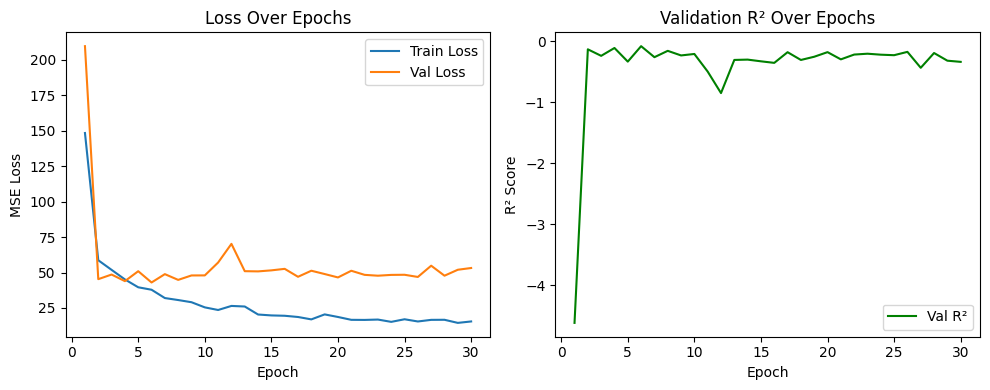

In [30]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_r2s, label='Val R²', color='green')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Validation R² Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


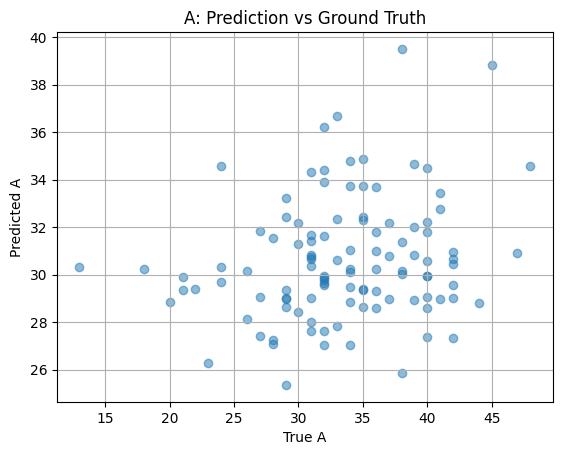

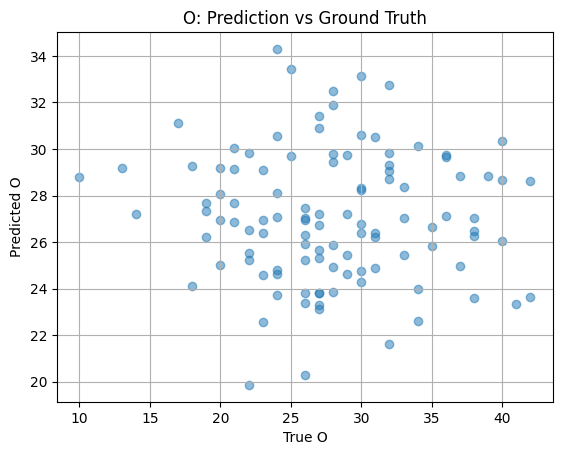

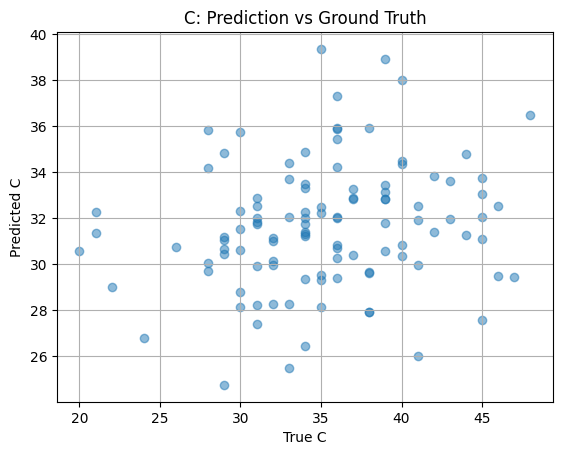

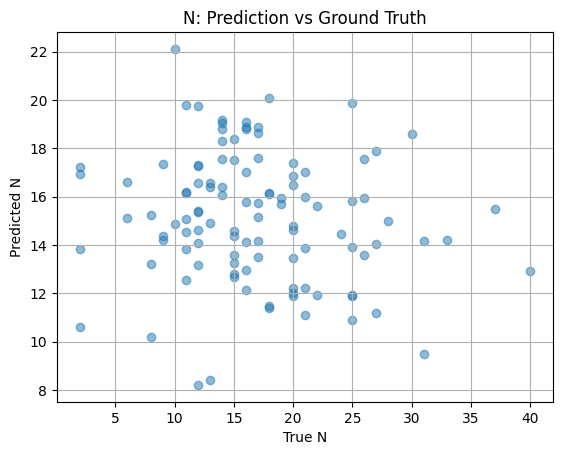

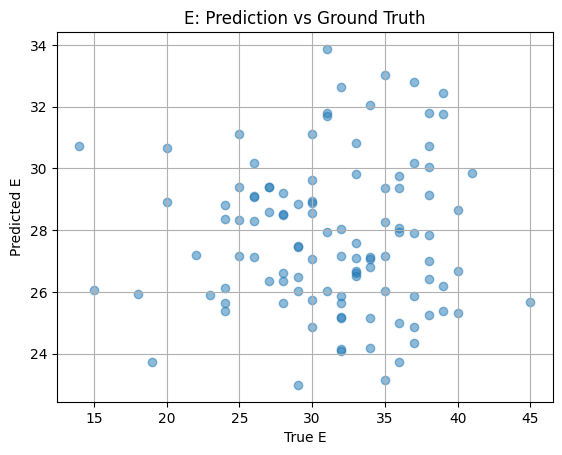

In [31]:

import matplotlib.pyplot as plt

preds, labels = [], []
CNN_model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = CNN_model(x)
        preds.append(out.cpu())
        labels.append(y.cpu())

preds = torch.cat(preds).numpy()
labels = torch.cat(labels).numpy()

for i, trait in enumerate(['A', 'O', 'C', 'N', 'E']):
    plt.scatter(labels[:, i], preds[:, i], alpha=0.5)
    plt.xlabel(f"True {trait}")
    plt.ylabel(f"Predicted {trait}")
    plt.title(f"{trait}: Prediction vs Ground Truth")
    plt.grid(True)
    plt.show()


# GNN Approach

In [32]:
!pip install torch-geometric

     ---------------------------------------- 1.1/1.1 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 453.3/453.3 kB 9.6 MB/s eta 0:00:00
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
     ---------------------------------------- 44.0/44.0 kB ? eta 0:00:00
     ---------------------------------------- 45.9/45.9 kB ? eta 0:00:00
     ---------------------------------------- 41.5/41.5 kB ? eta 0:00:00
     ---------------------------------------- 86.7/86.7 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
import torch
import numpy as np
import os

In [34]:
def build_graph_from_matrix(pca_matrix: np.ndarray, k: int = 8) -> Data:
    x = torch.tensor(pca_matrix, dtype=torch.float32)  # [N, 10]

    # k-NN graph based on PCA features
    A = kneighbors_graph(pca_matrix, n_neighbors=k, mode='connectivity', include_self=False)
    edge_index = torch.tensor(np.array(A.nonzero()), dtype=torch.long)  # [2, E]

    data = Data(x=x, edge_index=edge_index)
    return data

def build_subject_graphs(subject_path, k=8):
    graphs = []
    for i in range(1, 18):  # net_01.npy to net_17.npy
        path = os.path.join(subject_path, f"net_{i:02d}.npy")
        if os.path.exists(path):
            pca_matrix = np.load(path)
            graph = build_graph_from_matrix(pca_matrix, k)
            graphs.append(graph)
        else:
            print(f"Missing: {path}")  # Optional: warn about missing files
    return graphs

In [37]:
from torch.utils.data import Dataset

class MultiGraphDataset(Dataset):
    def __init__(self, root_dir, label_map, transform=None):
        self.root_dir = root_dir
        self.label_map = label_map
        self.transform = transform

        self.subject_dirs = []
        for subject_folder in os.listdir(root_dir):
            subject_path = os.path.join(root_dir, subject_folder)
            subject_id = subject_folder.replace("subject_", "")
            if os.path.isdir(subject_path) and os.listdir(subject_path) and not np.isnan(label_map[subject_id]).any():
                self.subject_dirs.append((subject_path, subject_id))
            #if os.path.isdir(subject_path) and os.listdir(subject_path) and subject_id in gender_map:
                #self.subject_dirs.append((subject_path, subject_id))

    def __len__(self):
        return len(self.subject_dirs)

    def __getitem__(self, idx):
        subject_path, subject_id = self.subject_dirs[idx]
        graphs = build_subject_graphs(subject_path)  # List of 17 PyG Data objects

        if self.transform:
            graphs = [self.transform(g) for g in graphs]

        label_array = self.label_map[subject_id]
        label_tensor = torch.tensor(label_array, dtype=torch.float32)
        #label_tensor = torch.tensor([gender_map[subject_id]], dtype=torch.float32)


        return graphs, label_tensor
    def getpatientid(self, idx):
        return self.subject_dirs[idx][1]

In [39]:
import pandas as pd

#label_df = pd.read_csv('/content/drive/MyDrive/APS360/APS360_Group/data/unrestricted_5_22_56_15.csv')
label_df = pd.read_csv('C:/Users/namgy/OneDrive/Desktop/APS360/data/unrestricted_5_22_56_15.csv')
#print(label_df.columns)

label_df['Subject'] = label_df['Subject'].astype(str)

trait_columns = ['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']
label_map = {
    row['Subject']: row[trait_columns].values.astype(np.float32)
    for _, row in label_df.iterrows()
}


In [41]:
# Create dataset instance
multi_graph_dataset = MultiGraphDataset(
    root_dir="C:/Users/namgy/OneDrive/Desktop/APS360/data/output",
    label_map=label_map
)

# Test one sample
sample_graphs, sample_label = multi_graph_dataset[0]
print(f"Subject ID: {multi_graph_dataset.getpatientid(0)}")
print(f"# of graphs: {len(sample_graphs)}")
print(f"Trait label: {sample_label}")
for i in range(len(sample_graphs)):
    print(f"Graph {i+1} → Nodes: {sample_graphs[i].num_nodes}, Edges: {sample_graphs[i].num_edges}")

Subject ID: 100206
# of graphs: 17
Trait label: tensor([29., 23., 26., 21., 32.])
Graph 1 → Nodes: 1228, Edges: 9824
Graph 2 → Nodes: 1053, Edges: 8424
Graph 3 → Nodes: 1826, Edges: 14608
Graph 4 → Nodes: 1555, Edges: 12440
Graph 5 → Nodes: 1114, Edges: 8912
Graph 6 → Nodes: 1110, Edges: 8880
Graph 7 → Nodes: 1575, Edges: 12600
Graph 8 → Nodes: 1046, Edges: 8368
Graph 9 → Nodes: 766, Edges: 6128
Graph 10 → Nodes: 660, Edges: 5280
Graph 11 → Nodes: 503, Edges: 4024
Graph 12 → Nodes: 1137, Edges: 9096
Graph 13 → Nodes: 1090, Edges: 8720
Graph 14 → Nodes: 670, Edges: 5360
Graph 15 → Nodes: 460, Edges: 3680
Graph 16 → Nodes: 1520, Edges: 12160
Graph 17 → Nodes: 1402, Edges: 11216


In [42]:
from torch_geometric.data import Batch

def multi_graph_collate(batch):
    """
    batch = list of (graphs_list, label_tensor)
    - graphs_list: list of 17 Data objects
    - label_tensor: trait vector [5]
    """
    graphs_per_network = list(zip(*[item[0] for item in batch]))  # Transpose: [B,17] → [17,B]
    batched_graphs = [Batch.from_data_list(glist) for glist in graphs_per_network]

    labels = torch.stack([item[1] for item in batch])  # Shape: [B, 5]
    return batched_graphs, labels

In [43]:
from torch.utils.data import DataLoader

train_size = int(0.8 * len(multi_graph_dataset))
val_size = int(0.1 * len(multi_graph_dataset))
test_size = len(multi_graph_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    multi_graph_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Adjust as needed
    shuffle=True,
    collate_fn=multi_graph_collate
)
val_loader = DataLoader(
    val_dataset,
    batch_size=4,  # Adjust as needed
    shuffle=False,
    collate_fn=multi_graph_collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size=4,  # Adjust as needed
    shuffle=False,
    collate_fn=multi_graph_collate
)

In [44]:
from torch.utils.data import Subset, DataLoader
import random

# Set seed for reproducibility
random.seed(42)

# Total dataset size
total_size = len(multi_graph_dataset)
subset_size = int(0.1 * total_size)

# Randomly select 10% of indices
subset_indices = random.sample(range(total_size), subset_size)

# Create the subset
small_dataset = Subset(multi_graph_dataset, subset_indices)

small_loader = DataLoader(
    small_dataset,
    batch_size=4,  # Adjust as needed
    shuffle=True,
    collate_fn=multi_graph_collate
)

In [45]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class MultiGraphGNN(torch.nn.Module):
    def __init__(self, input_dim=10, hidden_dim=64, graph_emb_dim=128, num_graphs=17, output_dim=5):
        super().__init__()

        self.gnn1 = GATConv(input_dim, hidden_dim)
        self.gnn2 = GATConv(hidden_dim, graph_emb_dim)

        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(num_graphs * graph_emb_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, output_dim)
        )

    def forward(self, batched_graphs_list):
        graph_embeddings = []

        for data in batched_graphs_list:
            x, edge_index, batch = data.x, data.edge_index, data.batch

            x = F.relu(self.gnn1(x, edge_index))
            x = F.relu(self.gnn2(x, edge_index))

            pooled = global_mean_pool(x, batch)
            graph_embeddings.append(pooled)

        fused = torch.cat(graph_embeddings, dim=1)

        out = self.fusion(fused)
        return out


In [46]:
def evaluate_gnn(model, loader, criterion, device, return_r2=False):
    model.eval()
    total_loss = 0.0
    all_outputs, all_labels = [], []

    with torch.no_grad():
        for graphs_list, labels in loader:
            graphs_list = [g.to(device) for g in graphs_list]
            labels = labels.to(device)

            outputs = model(graphs_list)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(loader)

    if return_r2:
        from sklearn.metrics import r2_score
        all_outputs = torch.cat(all_outputs).numpy()
        all_labels = torch.cat(all_labels).numpy()
        r2 = r2_score(all_labels, all_outputs, multioutput='uniform_average')
        return avg_loss, r2
        '''
    if return_r2:
        preds = torch.sigmoid(torch.cat(all_outputs)) > 0.5
        truths = torch.cat(all_labels) > 0.5
        acc = (preds == truths).float().mean().item()
        return avg_loss, acc
        '''


    return avg_loss
def train_gnn_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20):
    best_val_loss = float('inf')
    best_model_state = None

    train_losses, val_losses, val_r2s = [], [], []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        for graphs_list, labels in train_loader:
            graphs_list = [g.to(device) for g in graphs_list]
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(graphs_list)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss, val_r2 = evaluate_gnn(model, val_loader, criterion, device, return_r2=True)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_r2s.append(val_r2)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | R2: {val_r2:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, val_r2s


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device == torch.device("cuda"):
    print(f"Device name: {torch.cuda.get_device_name(0)}")
gnn_model = MultiGraphGNN(output_dim=5).to(device)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=1e-3, weight_decay=1e-4)

trained_gnn, train_losses, val_losses, val_r2s = train_gnn_model(
    gnn_model, train_loader, val_loader,  # You can split small_loader later
    criterion, optimizer, device,
    epochs=30,
)


Using device: cuda
Device name: NVIDIA GeForce RTX 4060
Epoch 1/30 - Train Loss: 110.0056 | Val Loss: 48.7088 | R2: -0.3606
Epoch 2/30 - Train Loss: 57.9861 | Val Loss: 49.0134 | R2: -0.3652
Epoch 3/30 - Train Loss: 55.6370 | Val Loss: 44.2771 | R2: -0.2398
Epoch 4/30 - Train Loss: 53.7973 | Val Loss: 44.8134 | R2: -0.2498
Epoch 5/30 - Train Loss: 53.5062 | Val Loss: 38.8722 | R2: -0.0693
Epoch 6/30 - Train Loss: 49.9097 | Val Loss: 38.3651 | R2: -0.0506
Epoch 7/30 - Train Loss: 50.3098 | Val Loss: 41.0319 | R2: -0.1323
Epoch 8/30 - Train Loss: 49.7107 | Val Loss: 38.5454 | R2: -0.0569
Epoch 9/30 - Train Loss: 50.1620 | Val Loss: 39.9009 | R2: -0.0981
Epoch 10/30 - Train Loss: 51.7212 | Val Loss: 37.7562 | R2: -0.0371
Epoch 11/30 - Train Loss: 50.5993 | Val Loss: 43.9749 | R2: -0.2207
Epoch 12/30 - Train Loss: 48.3123 | Val Loss: 37.6166 | R2: -0.0339
Epoch 13/30 - Train Loss: 49.7196 | Val Loss: 40.0949 | R2: -0.1138
Epoch 14/30 - Train Loss: 48.4958 | Val Loss: 40.9154 | R2: -0.1313


In [49]:
test_loss, test_r2 = evaluate(gnn_model, test_loader, criterion, device, return_r2=True)
print(f"Test Loss: {test_loss:.4f} | Test R²: {test_r2:.4f}")


AttributeError: 'list' object has no attribute 'to'

GAT approach:

Using device: cuda
Device name: NVIDIA A100-SXM4-40GB
Epoch 1/50 - Train Loss: 103.3123 | Val Loss: 52.0127 | R²: -0.2657
Epoch 2/50 - Train Loss: 57.5713 | Val Loss: 44.5724 | R²: -0.0393
Epoch 3/50 - Train Loss: 53.1073 | Val Loss: 44.2274 | R²: -0.0302
Epoch 4/50 - Train Loss: 52.1288 | Val Loss: 43.9703 | R²: -0.0235
Epoch 5/50 - Train Loss: 50.1298 | Val Loss: 50.5711 | R²: -0.1853
Epoch 6/50 - Train Loss: 49.9257 | Val Loss: 45.9879 | R²: -0.0731
Epoch 7/50 - Train Loss: 49.0113 | Val Loss: 48.1521 | R²: -0.1424
Epoch 8/50 - Train Loss: 49.5130 | Val Loss: 46.5583 | R²: -0.0905
Epoch 9/50 - Train Loss: 48.0999 | Val Loss: 48.1392 | R²: -0.1351
Epoch 10/50 - Train Loss: 48.4956 | Val Loss: 46.0224 | R²: -0.0762
Epoch 11/50 - Train Loss: 47.1819 | Val Loss: 45.4252 | R²: -0.0695
Epoch 12/50 - Train Loss: 47.9191 | Val Loss: 45.1117 | R²: -0.0539
Epoch 13/50 - Train Loss: 47.4175 | Val Loss: 44.5957 | R²: -0.0418
Epoch 14/50 - Train Loss: 47.6484 | Val Loss: 45.1778 | R²: -0.0560
Epoch 15/50 - Train Loss: 46.7897 | Val Loss: 44.7985 | R²: -0.0492
Epoch 16/50 - Train Loss: 47.1128 | Val Loss: 48.1919 | R²: -0.1353
Epoch 17/50 - Train Loss: 48.3685 | Val Loss: 47.9364 | R²: -0.1370
Epoch 18/50 - Train Loss: 47.8455 | Val Loss: 45.1800 | R²: -0.0543
Epoch 19/50 - Train Loss: 46.2970 | Val Loss: 44.3304 | R²: -0.0293
Epoch 20/50 - Train Loss: 47.3870 | Val Loss: 45.8593 | R²: -0.0679
Epoch 21/50 - Train Loss: 46.5255 | Val Loss: 45.5083 | R²: -0.0548
Epoch 22/50 - Train Loss: 46.4839 | Val Loss: 47.3099 | R²: -0.1139
Epoch 23/50 - Train Loss: 46.6954 | Val Loss: 46.8609 | R²: -0.1023
Epoch 24/50 - Train Loss: 45.7516 | Val Loss: 45.3633 | R²: -0.0548
Epoch 25/50 - Train Loss: 45.5698 | Val Loss: 49.6981 | R²: -0.1772
Epoch 26/50 - Train Loss: 45.6260 | Val Loss: 44.3383 | R²: -0.0276
Epoch 27/50 - Train Loss: 45.6030 | Val Loss: 45.6628 | R²: -0.0643
Epoch 28/50 - Train Loss: 46.3184 | Val Loss: 46.4034 | R²: -0.0784
Epoch 29/50 - Train Loss: 45.2129 | Val Loss: 44.5173 | R²: -0.0368
Epoch 30/50 - Train Loss: 45.2909 | Val Loss: 44.7359 | R²: -0.0395